In [1]:
!pip install evaluate datasets transformers torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, Dataset
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pathlib import Path

import torch
from tqdm import tqdm
from transformers import TrainingArguments, Trainer
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import evaluate

### Import Data

In [3]:
# mount drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
X_train_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_train.csv"
X_val_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_val.csv"
# X_test_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_test.csv"
X_test_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_test_clean.csv"
y_train_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/y_train.csv"
y_val_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/y_val.csv"
y_test_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/y_test_clean.csv"


X_train = pd.read_csv(X_train_path)
X_val = pd.read_csv(X_val_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_val = pd.read_csv(y_val_path)
y_test = pd.read_csv(y_test_path)

print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Training labels size: {len(y_train)} samples")
print(f"Validation labels size: {len(y_val)} samples")
print(f"Testing labels size: {len(y_test)} samples")

Training set size: 8000 samples
Validation set size: 1000 samples
Testing set size: 983 samples
Training labels size: 8000 samples
Validation labels size: 1000 samples
Testing labels size: 983 samples


### Prepare Data and Baseline Model

In [5]:
model_name = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
MAX_LENGTH = 512

In [7]:
def preprocess_dataset(data, tokenizer, summary_column="summary"):
  """
  Tokenizes the document and summary pairs using the provided tokenizer.
  """
  # Combine document and summary into a list of text pairs for batched tokenization
  text_pairs = list(zip(data["document"], data[summary_column]))

  encoded_inputs = tokenizer(
      text_pairs, # Pass the list of (document, summary) tuples
      max_length=MAX_LENGTH,
      padding="max_length",
      truncation=True,
      return_tensors="pt" # Return PyTorch tensors
  )

  # For a sequence classification task, we also need to include the labels.
  # Assuming 'label_binary' is the column containing the classification labels (0 or 1).
  # Convert the label to a PyTorch tensor and ensure it's a long type for classification loss functions.
  encoded_inputs["labels"] = torch.tensor(data['label_binary'], dtype=torch.long)

  return encoded_inputs

### Build Model

In [8]:
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [14]:
def fine_tune_model(
    model_name,
    tokenizer,
    train_data_X, # This is X_train DataFrame
    train_data_y, # This is y_train Series
    val_data_X,   # This is X_val DataFrame
    val_data_y,   # This is y_val Series
    batch_size = 16,
    num_epochs = 2
):
  """
  Preprocesses data using the selected tokenizer and fine-tunes a pre-trained model.
  """
  # Combine X and y into a single DataFrame for the Dataset conversion
  train_df = train_data_X.copy()
  train_df['label_binary'] = train_data_y

  val_df = val_data_X.copy()
  val_df['label_binary'] = val_data_y

  # Convert pandas DataFrames to datasets.Dataset objects
  train_dataset = Dataset.from_pandas(train_df)
  val_dataset = Dataset.from_pandas(val_df)

  preprocessed_train_data = train_dataset.map(preprocess_dataset, batched=True, fn_kwargs={'tokenizer': tokenizer})
  preprocessed_val_data = val_dataset.map(preprocess_dataset, batched=True, fn_kwargs={'tokenizer': tokenizer})

  training_args = TrainingArguments(
      output_dir="bert_hallucinations",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      eval_strategy="epoch",
      save_strategy="epoch",
      report_to="none"
  )

  trainer = Trainer(
      model=model_name,
      args=training_args,
      train_dataset=preprocessed_train_data,
      eval_dataset=preprocessed_val_data,
      compute_metrics=compute_metrics
  )

  trainer.train()

In [15]:
fine_tune_model(bert_model, bert_tokenizer, X_train, y_train, X_val, y_val)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.345300,0.422921,0.877000
2,0.138800,0.173709,0.942000


In [ ]:
# # copy model to drive
# !cp -r /content/bert_hallucinations/ /content/drive/MyDrive/NLP/LLM_Hallucination/

In [10]:
# reload fine-tuned model
model_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/bert_hallucinations/checkpoint-1000"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

## Results

In [16]:
# Prepare the test dataset
test_df = X_test.copy()
test_df['label_binary'] = y_test
test_dataset = Dataset.from_pandas(test_df)
preprocessed_test_data = test_dataset.map(preprocess_dataset, batched=True, fn_kwargs={'tokenizer': bert_tokenizer})

# Re-instantiate TrainingArguments for evaluation (output_dir is needed)
eval_args = TrainingArguments(
    output_dir="bert_hallucinations_eval", # A different directory for eval outputs if desired
    per_device_eval_batch_size=16,
    report_to="none"
)

# Instantiate a Trainer with the fine-tuned model for prediction
eval_trainer = Trainer(
    model=bert_model,
    args=eval_args
)

# Get predictions on the test set
predictions_output = eval_trainer.predict(preprocessed_test_data)

# Extract predicted logits and true labels
predictions_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted labels (0 or 1)
predicted_labels = np.argmax(predictions_logits, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Optionally, print a full classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Map:   0%|          | 0/983 [00:00<?, ? examples/s]

Test Accuracy: 0.9288
Test Precision: 0.8922
Test Recall: 0.9756
Test F1-Score: 0.9320

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       491
           1       0.89      0.98      0.93       492

    accuracy                           0.93       983
   macro avg       0.93      0.93      0.93       983
weighted avg       0.93      0.93      0.93       983



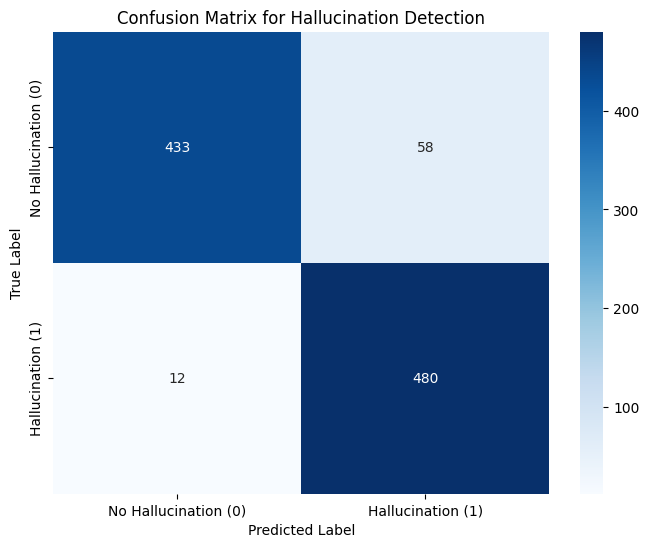

In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels for better readability
class_labels = ['No Hallucination (0)', 'Hallucination (1)']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Hallucination Detection')
plt.show()


In [18]:
def compute_ece(y_prob, y_true, n_bins=20):
    """
    y_prob: numpy array of predicted probabilities for the positive class, shape [N]
    y_true: numpy array of true labels (0 or 1), shape [N]
    n_bins: number of confidence bins
    """
    y_prob = np.asarray(y_prob)
    y_true = np.asarray(y_true)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    N = y_true.shape[0]

    for i in range(n_bins):
        start = bin_edges[i]
        end = bin_edges[i + 1]

        if i == 0:
            in_bin = (y_prob >= start) & (y_prob <= end)
        else:
            in_bin = (y_prob > start) & (y_prob <= end)

        bin_count = np.sum(in_bin)
        if bin_count == 0:
            continue

        bin_probs = y_prob[in_bin]
        bin_labels = y_true[in_bin]

        # Empirical positive rate in this bin
        bin_acc = bin_labels.mean()          # fraction of y=1
        bin_conf = bin_probs.mean()          # average predicted P(y=1)

        ece += (bin_count / N) * abs(bin_acc - bin_conf)

    return ece


In [19]:
logits = torch.tensor(predictions_logits)

if logits.shape[1] == 1:
  # Binary classifier for single logit
  y_prob = torch.sigmoid(logits).squeeze(1).numpy()
else:
  # Use softmax to get probability of class 1
  y_prob = torch.softmax(logits, dim=-1)[:, 1].numpy()

ece = compute_ece(y_prob, true_labels)
print("Test set ECE:")
print(f"ECE: {ece:.4f}")

Test set ECE:
ECE: 0.0542


## Robustness Testing

In [20]:
para_test_df = X_test.copy()
para_test_df['label_binary'] = y_test
para_test_dataset = Dataset.from_pandas(para_test_df)
preprocessed_test_data_para = test_dataset.map(
    preprocess_dataset,
    batched=True,
    fn_kwargs={"tokenizer": bert_tokenizer, "summary_column": "summary_paraphrased"},
)

# Re-instantiate TrainingArguments for evaluation (output_dir is needed)
eval_args = TrainingArguments(
    output_dir="berta_hallucinations_para_eval", # A different directory for eval outputs if desired
    per_device_eval_batch_size=16,
    report_to="none"
)

# Instantiate a Trainer with the fine-tuned model for prediction
eval_trainer = Trainer(
    model=bert_model,
    args=eval_args
)

# Get predictions on the test set
predictions_output = eval_trainer.predict(preprocessed_test_data_para)

# Extract predicted logits and true labels
predictions_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted labels (0 or 1)
predicted_labels = np.argmax(predictions_logits, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Optionally, print a full classification report
print("\nClassification Report For Paraphrased Test Set:")
print(classification_report(true_labels, predicted_labels))

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

Test Accuracy: 0.7986
Test Precision: 0.7181
Test Recall: 0.9837
Test F1-Score: 0.8302

Classification Report For Paraphrased Test Set:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75       491
           1       0.72      0.98      0.83       492

    accuracy                           0.80       983
   macro avg       0.85      0.80      0.79       983
weighted avg       0.85      0.80      0.79       983



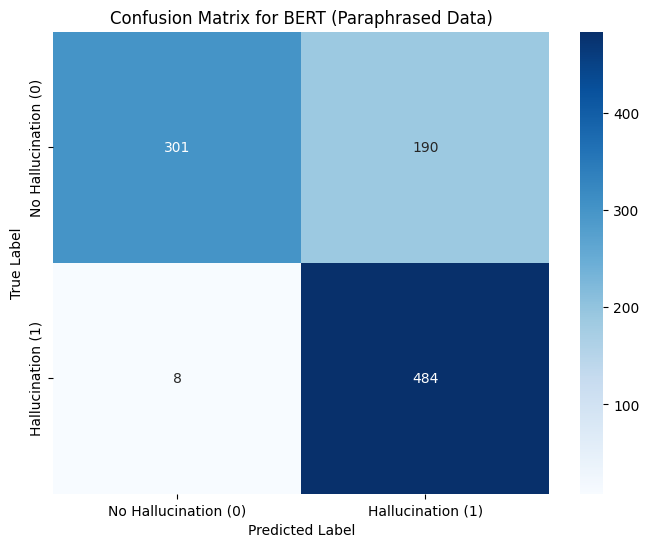

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels for better readability
class_labels = ['No Hallucination (0)', 'Hallucination (1)']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BERT (Paraphrased Data)')
plt.show()


In [22]:
logits = torch.tensor(predictions_logits)

if logits.shape[1] == 1:
  # Binary classifier for single logit
  y_prob = torch.sigmoid(logits).squeeze(1).numpy()
else:
  # Use softmax to get probability of class 1
  y_prob = torch.softmax(logits, dim=-1)[:, 1].numpy()

ece = compute_ece(y_prob, true_labels)
print("Paraphrased test set ECE:")
print(f"ECE: {ece:.4f}")

Paraphrased test set ECE:
ECE: 0.1799
